# Feature Engineering

Combine all of the feature calculations into a single notebook and output a full featue set as a dataframe.

### Import Libraries

In [1]:
#import required libraries
from utils import aws # used to create aws session and load parquet 
import pandas as pd
import numpy as np
import ast 
import dask.dataframe as dd

### Load LOB Data

Currently this is run using the sample dataset, but going forward will need to be run using the full LOB dataset.

In [2]:
#load sample lob from s3 to a dask dataframe
samp_lob_ddf = aws.load_s3_file_as_ddf("s3://dsmp-ol2/processed-data/lob_sample_data.parquet")

In [3]:
#compute the dask datafram to a pandas dataframe
df = samp_lob_ddf.compute()

In [4]:
df.head()

,Timestamp,Exchange,Bid,Ask,Date,Mid_Price
0,0.000,Exch0,[],[],2025-01-02,NaN
1,0.279,Exch0,"[[1, 6]]",[],2025-01-02,NaN
2,1.333,Exch0,"[[1, 6]]","[[800, 1]]",2025-01-02,400.5
3,1.581,Exch0,"[[1, 6]]","[[799, 1]]",2025-01-02,400.0
4,1.643,Exch0,"[[1, 6]]","[[798, 1]]",2025-01-02,399.5


### Preprocessing

In [5]:
#convert string to lists
df['Bid'] = df['Bid'].apply(ast.literal_eval)
df['Ask'] = df['Ask'].apply(ast.literal_eval)

In [6]:
#drop missing rows in mid price
df = df.dropna(subset=['Mid_Price']) # This assumes the number of missing mid prices is small
# TODO following EDA determine if this is the correct decision

## Feature Engineering

## Simple Financial Features

### Volume
#### Volume and OBV

- On Balance Volume (OBV) confirm trends by analysing volume changes. Persistent rising obv suggests accumulation / buying pressure, associated with upward price movement. Persistent falling obv suggests distribution / selling pressure. Theory is that changes in volume preced price movements. Increase in volume often precedes a change in price direction. Use as trend, reversal and breakout confirmation.

- If today's close is higher than yesterday's close, then OBV = Previous OBV + today's volume.
- If today's close is lower than yesterday's close, then OBV = Previous OBV - today's volume.
- If today's close is equal to yesterday's close, then OBV = Previous OBV.

In [7]:
#calculate order volume at each timestep
df['Total_Order_Volume'] = df['Bid'].apply(lambda x: sum([qty for price, qty in x])) + \
               df['Ask'].apply(lambda x: sum([qty for price, qty in x]))

#calc obv
#should be done using close but we can approximate with mid but might not be as reliable
#TODO check this calculation, I think close is the previous days last traded price, we could get this from the tape.
direction = df['Mid_Price'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df['OBV'] = (direction * df['Total_Order_Volume']).cumsum()

#### Volume Imbalance

Volume Imbalance is a metric used to assess the balance between supply and demand in a market at any given time, based on order book data. It compares the total volume of buy orders (bids) to the total volume of sell orders (asks), providing insight into potential price movements.

**Formula**

The Volume Imbalance ($VI$) is calculated using the formula:

$$ VI = \frac{V_{\text{bids}} - V_{\text{asks}}}{V_{\text{bids}} + V_{\text{asks}}} $$

where:
- $V_{\text{bids}}$ is the total volume of all bid orders.
- $V_{\text{asks}}$ is the total volume of all ask orders.

**Interpretation**

- $VI$ ranges from -1 to 1.
- A $VI$ closer to 1 indicates a higher volume of bids relative to asks, suggesting upward pressure on price.
- A $VI$ closer to -1 indicates a higher volume of asks relative to bids, suggesting downward pressure on price.
- A $VI$ around 0 indicates a balance between bid and ask volumes, suggesting a stable market condition without clear directional pressure on price.

In [8]:
def calculate_volume_imbalance(row):
    #calculate total bid volume
    total_bid_volume = sum([volume for _, volume in row['Bid']])
    
    #calculate total ask volume
    total_ask_volume = sum([volume for _, volume in row['Ask']])
    
    #error handling (div by 0)
    total_volume = total_bid_volume + total_ask_volume
    if total_volume == 0:
        return 0  #return 0 imbalance when there are no bids or asks
    
    #calculate volume imbalance
    volume_imbalance = (total_bid_volume - total_ask_volume) / total_volume
    return volume_imbalance

#apply
df['Total_Volume_Imbalance'] = df.apply(calculate_volume_imbalance, axis=1)


### Price discovery
#### Weighted Mid-Price by Order Imbalance

Given **Mid Price** ($M$) is already calculated, we calculate **Order Imbalance** ($I$) and the **Weighted Mid Price** ($M_W$) as follows:

**Order Imbalance**
With $V_B$ representing the volume of the best bid and $V_A$ representing the volume of the best ask, the order imbalance ($I$) is calculated by the formula:

$$ I = \frac{V_B - V_A}{V_B + V_A} $$

**Weighted Mid Price by Order Imbalance**
We adjust the mid price based on the order imbalance using the formula:

$$ M_W = M \times (1 + k \times I) $$

Here, $k$ is a scaling factor that modulates the effect of the order imbalance on the mid price. This factor can be empirically determined to best reflect the impact of order volume differences on the price.

This approach allows us to adjust the given mid price considering the balance or imbalance between buy and sell orders, reflecting a more nuanced market value.

In [9]:
#first we need to empirically define k
# TODO Fix k in the test set wih the k calculated in the train set

#future mid-price 
df['Mid_Price_Future'] = df['Mid_Price'].shift(-1)

#calc price change
df['Price_Change'] = df['Mid_Price_Future'] - df['Mid_Price']

def calculate_order_imbalance(row):
    if row['Bid'] and row['Ask']:
        volume_bid = sum([bid[1] for bid in row['Bid']])
        volume_ask = sum([ask[1] for ask in row['Ask']])
        return (volume_bid - volume_ask) / (volume_bid + volume_ask)
    return np.nan

#calc order imbalance for each row
df['Order_Imbalance'] = df.apply(calculate_order_imbalance, axis=1)  

In [10]:
#use regression to get value for k
from sklearn.linear_model import LinearRegression

#filter out nan
filtered_df = df.dropna(subset=['Order_Imbalance', 'Price_Change'])

X = filtered_df[['Order_Imbalance']].values.reshape(-1, 1)
y = filtered_df['Price_Change'].values

#fit linear regression model
model = LinearRegression()
model.fit(X, y)

#coefficient of 'Order_Imbalance' as 'k'
k = model.coef_[0]

print(f"Derived k value: {k}")

Derived k value: -0.10495033692166034


In [11]:
#calc weighted mid price col
import pandas as pd

def calculate_weighted_mid_price(row, k):
    #check if nan
    if pd.isna(row['Mid_Price']):
        return row['Mid_Price']  #return original if nan
    
    imbalance = row['Order_Imbalance']
    
    #adjust mid price based on imbalance
    weighted_mid_price = row['Mid_Price'] * (1 + k * imbalance)
    
    return weighted_mid_price

#apply
df['Weighted_Mid_Price'] = df.apply(calculate_weighted_mid_price, k=k, axis=1)

#### Bid-Ask Spread and Level-1 Data

Bid-ask spread represents the difference between the highest price buyers are willing to pay (**bid price**) and the lowest price sellers are willing to accept (**ask price**). We can use it as a key indicator of market liquidity and efficiency.

We calculate it by:

$$ \text{Bid-Ask Spread} = \text{Ask Price} - \text{Bid Price} $$

where:
- $\text{Ask Price}$ is the lowest price a seller is willing to accept.
- $\text{Bid Price}$ is the highest price a buyer is willing to pay.


A narrower (lower) spread often indicates a more liquid market, where transactions can occur more easily at prices close to the market's consensus value. A wider (higher) spread suggests lower liquidity, higher transaction costs, and potentially more volatility.

Level-1 data refers to the top level of the limit order book. This is the order with the highest bid price (that came in first) and the lowest ask price. 

In [12]:
def calculate_level_1(row):
    if not row['Bid'] or not row['Ask']:  # check if either list is empty
        return pd.Series([None, None, None, None, None, None], index=['Bid_Ask_Spread', 'Level_1_Bid_Price', 'Level_1_Ask_Price', 'Level_1_Bid_Quantity', 'Level_1_Ask_Quantity', 'Level_1_Order_Imbalance'])
    
    # extract highest bid price and lowest ask price
    highest_bid_price = row['Bid'][0][0]  # assuming first entry is the highest bid
    lowest_ask_price = row['Ask'][0][0]  # assuming first entry is the lowest ask
    highest_bid_qnt = row['Bid'][0][1]  # assuming first entry is the highest bid
    lowest_ask_qnt = row['Ask'][0][1]  # assuming first entry is the lowest ask
    
    # calculate the spread
    bid_ask_spread = lowest_ask_price - highest_bid_price

    # calculate the level 1 order imbalance
    l1_order_imbalance = highest_bid_qnt - lowest_ask_qnt

    return pd.Series([bid_ask_spread, highest_bid_price, lowest_ask_price, highest_bid_qnt, lowest_ask_qnt, l1_order_imbalance], index=['Bid_Ask_Spread', 'Level_1_Bid_Price', 'Level_1_Ask_Price', 'Level_1_Bid_Quantity', 'Level_1_Ask_Quantity', 'Level_1_Order_Imbalance'])

# apply
df[['Bid_Ask_Spread', 'Level_1_Bid_Price', 'Level_1_Ask_Price', 'Level_1_Bid_Quantity', 'Level_1_Ask_Quantity', 'Level_1_Order_Imbalance']] = df.apply(calculate_level_1, axis=1)

## Complex Financial Features

### Momentum
#### RSI

RSI (relative strength index) identifies popular, overbought and oversold conditions. It calculates with avg gain, avg loss and relative strength. You need to check direction not just value to understand trend. 

- above 70- overbought
- below 30- oversold
- 50-70- a strong bullish trend
- 30-50 -a moderate bullish trend
- 50-30- a strong bearish trend
- 70-40- a moderate bearish trend

In [13]:
#rsi
delta = df['Mid_Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=20).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=20).mean()
RS = gain / loss

df['RSI'] = 100 - (100 / (1 + RS))

#### Stochastic RSI

The Stochastic RSI is an indicator used to identify overbought and oversold conditions by measuring the level of the RSI relative to its high and low range over a specific period. It is derived from the RSI but provides more sensitivity and a higher frequency of trading signals by applying the stochastic oscillator formula to RSI values.

$$ \text{StochRSI} = \frac{\text{RSI} - \text{Min(RSI, n)}}{\text{Max(RSI, n)} - \text{Min(RSI, n)}} $$

where:
- $\text{RSI}$ is the current value of the Relative Strength Index,
- $\text{Min(RSI, n)}$ is the minimum RSI value over the last $n$ periods,
- $\text{Max(RSI, n)}$ is the maximum RSI value over the last $n$ periods,
- $n$ is the specified period over which the highs and lows are calculated.

In [14]:
#min and max RSI values over window
min_rsi = df['RSI'].rolling(window=20).min()
max_rsi = df['RSI'].rolling(window=20).max()

#calc Stochastic RSI
df['Stochastic_RSI'] = (df['RSI'] - min_rsi) / (max_rsi - min_rsi)

In [15]:
#scale to 0-100 range (better for interpretation and comparison to other oscillators)
df['Stochastic_RSI'] = df['Stochastic_RSI'] * 100

#### Awesome Oscillator

The awesome oscillator is a market momentum indicator that compares the recent market momentum, with the momentum over a broader timeframe, by calculating the difference between a 34 period and a 5 period simple moving averages (SMA) of the median prices (or mid prices when median prices are not available).
Calc by-

$$
AO = SMA_{5} - SMA_{34}
$$

where
- $SMA_{5}$ is the 5-period simple moving average of the mid-prices.
- $SMA_{34}$ is the 34-period simple moving average of the mid-prices.

The AO serves to detect changes in the market's momentum and potentially signal upcoming market reversals.

In [16]:
#TODO How will these features work once we have run EMA on the mid-price?
# Use the raw data to create features and use the noise reduced mid-price as a target

In [17]:
#calculate sma for 34 and 5 periods
sma_34 = df['Mid_Price'].rolling(window=34, min_periods=1).mean()
sma_5 = df['Mid_Price'].rolling(window=5, min_periods=1).mean()

#calc ao
df['Awesome_Oscillator'] = sma_5 - sma_34

#### Accelerator Oscillator

The accelerator oscillator measures the acceleration or deceleration of the current market driving force, essentially indicating whether the market force is increasing or decreasing.

Its calculated as the difference between the 5-period simple moving average of the awesome oscillator, and the ao itself:

$$
AC = AO - SMA_{5}(AO)
$$

where-
- $AO$ is the awesome oscillator.
- $SMA_{5}(AO)$ is the 5-period simple moving average of the awesome oscillator values.

It can be used to confirm ao signals or predict possible reversals.

In [18]:
ao_sma_5 = df['Awesome_Oscillator'].rolling(window=5, min_periods=1).mean()
df['Accelerator_Oscillator'] = df['Awesome_Oscillator'] - ao_sma_5

### Trend

#### Moving Average Convergence/Divergence Oscillator

MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.

$$
\text{MACD} = EMA_{12}(\text{price}) - EMA_{26}(\text{price})
$$
$$
\text{Signal Line} = EMA_{9}(\text{MACD})
$$

where
- $EMA_{12}$ and $EMA_{26}$ are the exponential moving averages for 12 and 26 periods, respectively.
- The Signal Line is the exponential moving average of the MACD itself.

In [19]:
#calc macdd and signal

#12 and 26 industry standards
ema_12 = df['Mid_Price'].ewm(span=12, adjust=False).mean()
ema_26 = df['Mid_Price'].ewm(span=26, adjust=False).mean()

df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

#### Hull Moving Average

Hull ma reduces the lag of traditional moving averages with improved smoothing and responsiveness.

Calc a weighted moving average with period half the length of the Hull MA, then calculate a WMA for the full period of the Hull MA and subtract it from the first WMA calculation, and finally, calculate a WMA of the result with a period the square root of the Hull MA length.

$$
\text{Hull MA} = WMA(2 * \text{WMA}(n/2) - \text{WMA}(n), \sqrt{n})
$$

where
- $WMA(n)$ is the weighted moving average over $n$ periods.
- $\sqrt{n}$ is the square root of the period $n$.

In [20]:
#calc
hull_ma_period = int(np.sqrt(9)) #9 isn't industry standard just suggested starting point- may want to experiment here

wma_9 = df['Mid_Price'].rolling(window=9).apply(lambda x: np.dot(x, np.arange(1, 10)) / np.sum(
    np.arange(1, 10)), raw=True)

df['Hull_MA'] = wma_9.rolling(window=hull_ma_period).mean()

#### Keltner Channels

Keltner channels are volatility based envelopes set above and below an exponential moving average.

$$
\text{Middle Line} = EMA_{20}(\text{price})
$$
$$
\text{Upper Channel Line} = \text{Middle Line} + 2 \times ATR_{20}
$$
$$
\text{Lower Channel Line} = \text{Middle Line} - 2 \times ATR_{20}
$$

where
- $EMA_{20}$ is the 20-period exponential moving average.
- $ATR_{20}$ is the 20-period average true range.

In [21]:
#calc
ema_20 = df['Mid_Price'].ewm(span=20, adjust=False).mean()

atr = df['Mid_Price'].rolling(window=20).apply(lambda x: np.max(x) - np.min(x), raw=True)

df['Keltner_Channel_Middle'] = ema_20
df['Keltner_Channel_Upper'] = ema_20 + 2 * atr
df['Keltner_Channel_Lower'] = ema_20 - 2 * atr

#### Detrended Price Oscillator

Detrended price oscillator is an indicator designed to remove the trend from price and allow the measurement of the length and magnitude of price cycles from peak to peak or trough to trough.

DPO is calculated by subtracting the displaced moving average from the price \( \frac{lookback\ period}{2} + 1 \) periods ago.

$$
\text{DPO} = P_{t - \left(\frac{\text{lookback period}}{2} + 1\right)} - SMA_{t - \left(\frac{\text{lookback period}}{2}\right)}
$$

where
- \( P_{t} \) is the price at time \( t \).
- \( SMA \) is the simple moving average over the lookback period.
- The lookback period is the number of periods used to calculate the SMA and displace it.

By removing trends from the price data, the DPO helps to identify cycles and overbought or oversold conditions.

In [22]:
#efine lookback period
lookback_period = 20

#calc sma
df['SMA_20'] = df['Mid_Price'].rolling(window=lookback_period).mean() #may already have this from noise suppression?

#calc detrended 
#shift sma backwards by (lookback_period / 2 + 1) periods
df['DPO'] = df['Mid_Price'].shift(int(lookback_period / 2 + 1)) - df['SMA_20'].shift(int(lookback_period / 2))

### Volatility

#### Bollinger Bands

- Bollinger Bands- moveing average calc over specified period e.g. 20 days. + bands for moving average + or - 2 Standard deviations. (Could be 1.5 or 2.5) 1.9-2.2 is usual for algorithmic trading. Identify volatility and potential trend reversals. When prices are near the upper band the asset may be overbought indicating a possible reversal or pullback. When prices are near the lower band- asset may be oversold suggesting a upward reversal.

In [23]:
#bollinger bands
MA = df['Mid_Price'].rolling(window=20).mean() #over 20 periods
SD = df['Mid_Price'].rolling(window=20).std()

df['Upper_BB'] = MA + (2 * SD) #upper bb
df['Lower_BB'] = MA - (2 * SD) #lower bb

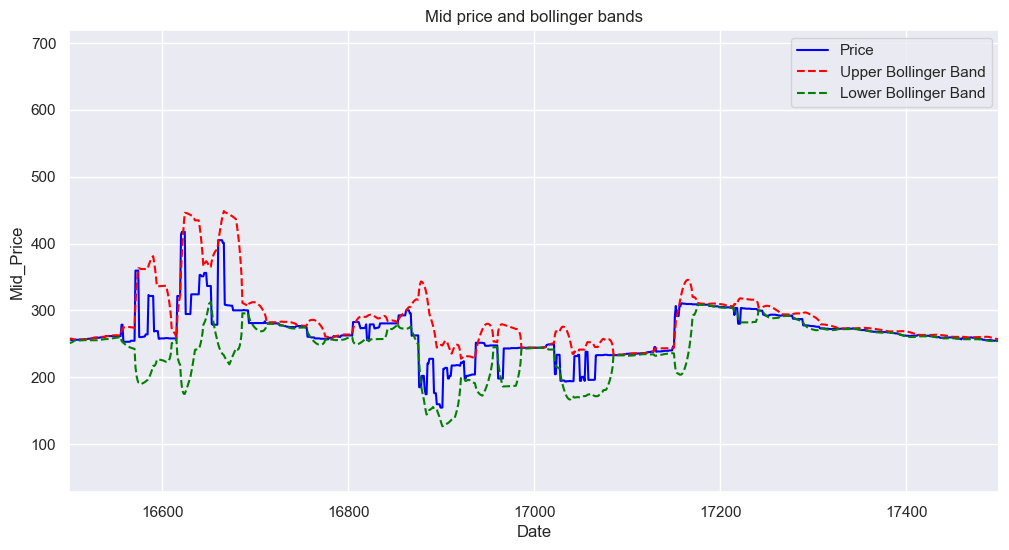

In [24]:
#plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['Mid_Price'], label='Price', color='blue')
plt.plot(df.index, df['Upper_BB'], label='Upper Bollinger Band', linestyle='--', color='red')
plt.plot(df.index, df['Lower_BB'], label='Lower Bollinger Band', linestyle='--', color='green')

#truncate to see pattern
start_index = 16500  
end_index = 17500  
plt.xlim(start_index, end_index)

plt.xlabel('Date')
plt.ylabel('Mid_Price')
plt.title('Mid price and bollinger bands')
plt.legend()

plt.show()

#### Realised Semi Variance

Realised semi-variance is a measure of the downside risk of an asset's returns. It's similar to realised variance but considers only the returns that fall below a certain threshold (typically, returns less than zero, focusing on negative returns). Realised semi-variance provides insight into the volatility resulting from negative market movements, which is useful for risk management purposes.

Calculated by-

$$
\text{Realised Semi-Variance} = \sum_{i=1}^{n} \min(r_i, 0)^2
$$

where $r_i$ represents the log return at interval $i$, and $n$ is the total number of intervals.

I will need to create this over a rolling window so it can apture how downside volatility changing over time. 

In [25]:
#calc log returns (natural log of ratio of its final price to its initial price)
df['Log_Returns'] = np.log(df['Mid_Price'] / df['Mid_Price'].shift(1))

#define window size 
window_size = 20 #choosing 20 to be consistent with bollinger bands 

#calculate realised semi-variance for each window
df['Realised_Semi_Variance'] = df['Log_Returns'].rolling(window=window_size, min_periods=1).apply(lambda x: np.sum(
    np.minimum(x, 0)**2), raw=True)

In [26]:
nan_count = df['Log_Returns'].isna().sum()

print(f"Number of NaN values in 'Log_Returns': {nan_count}")

Number of NaN values in 'Log_Returns': 1


In [27]:
df = df.dropna(subset=['Log_Returns'])

#### Realised Volatility

Realised volatility measures the variation in prices over a period and is a common measure of financial market volatility. For a rolling window calculation, we use log returns and square them to represent variance, which underpins volatility. The realised volatility over the rolling window is the square root of the rolling sum of squared log returns

This calculation provides a dynamic measure of volatility that updates over time, capturing the changing risk profile of the asset.

In [28]:
#def rolling window
window_size = 20

#calc squared log returns
df['Squared_Log_Returns'] = df['Log_Returns'] ** 2

#calc rolling realised volatility
df['Realised_Volatility'] = np.sqrt(df['Squared_Log_Returns'].rolling(window=window_size).sum())

print((df['Squared_Log_Returns'] < 0).sum())

0


#### Realised Bipower Variation

Realised bipower variation is a measure used to estimate the variance of financial asset returns, focusing specifically on the continuous component of price movements and excluding jumps. It is particularly useful in high-frequency finance for analysing volatility under normal market conditions. Calculated as-

$$
RBV = \frac{\pi}{2} \cdot \sum_{i=1}^{n-1} |r_i| \cdot |r_{i+1}|
$$

where:
- $|r_i|$ is the absolute value of the log return at interval $i$,
- $n$ is the total number of log returns in the series.

RBV isolates the continuous part of price movements by leveraging the properties of bipower measures, which provides us with a robust estimate of volatility that excludes large, discontinuous jumps.

In [29]:
#calc absolute log returns
df['Abs_Log_Returns'] = df['Log_Returns'].abs()

#calc realised bipower variation
#using .shift(-1) to get r_{i+1} for each r_i, multiplying adjacent abs returns
df['Realised_Bipower_Variation'] = (np.pi / 2) * (df['Abs_Log_Returns'] * df['Abs_Log_Returns'].shift(
    -1)).rolling(window=2).sum()

#### Jump Variation

Jump variation is a measure used to isolate the discontinuous (jump) components in asset prices, distinguishing them from the continuous components typically captured by other volatility measures. This distinction is particularly relevant in financial markets where sudden price movements can have significant implications.


**Total quadratic variation** ($TQV$) encompasses both continuous movements and jumps in the asset's price. It is calculated as the sum of squared log returns over a specific period.

$$TQV = \sum_{i=1}^{n} r_i^2$$
   where $r_i$ is the log return at interval $i$.


**Realised bipower variation** ($RBV$) estimates the continuous component of price movements, excluding jumps, by considering the product of absolute log returns for adjacent periods.

$RBV = \frac{\pi}{2} \cdot \sum_{i=1}^{n-1} |r_i| \cdot |r_{i+1}|$$

This uses adjacent pairs of absolute log returns to approximate the continuous component of volatility.

**Realised bipower variation** ($JV$) isolates the jump component by subtracting the continuous component ($RBV$) from the total variation ($TQV$).

$$JV = TQV - RBV$$

In [30]:
#squared log returns already calculated

#calc total quadratic variation as the sum of squared log returns
df['Total_Quadratic_Variation'] = df['Squared_Log_Returns'].rolling(window=20).sum()

#calc jump variation
df['Jump_Variation'] = df['Total_Quadratic_Variation'] - df['Realised_Bipower_Variation']

#### Spot Volatility - Removed as not working and unsure how to fix

Spot volatility reflects the instantaneous volatility of an asset, capturing the expected level of fluctuation in its price at any given moment. This approach is particularly useful in high-frequency trading and market microstructure analysis, where actual transaction data may be sparse but quote data (bids and asks) are available.

**GARCH Model**
 The GARCH model is then fitted to the log returns. GARCH models are used to estimate time-varying volatility, taking into account the conditional variance of past errors and past variances.
   
A basic GARCH(1,1) model includes one lag of squared residuals and one lag of conditional variance, capturing the clustering of volatility over time.

**Forecasting Spot Volatility**
Using the fitted GARCH model, forecast next periodvolatility to estimate the spot volatility. The forecasted variance ($\hat{\sigma}^2_t$) from the GARCH model provides an estimate of the expected volatility for the next period:

   $$ \text{Spot Volatility} = \sqrt{\hat{\sigma}^2_t} $$

In [31]:
#log returns already calculated

# from arch import arch_model

# #fit GARCH(1,1) model
# am = arch_model(df['Log_Returns']*100, vol='Garch', p=1, q=1, mean='Zero')
# res = am.fit(update_freq=5, disp='off')
             
             
# #forecast next period's volatility 
# forecasts = res.forecast(horizon=1)

# #extract last forecasted variance and take the square root for spot volatility
# df['Spot_Volatility'] = np.sqrt(forecasts.variance.iloc[-1] / 100)

### Smoothing

#### Savitzky-golay filter

The Savitzky-golay filter is used to smooth data points and increase data precision without distorting the signal tendency. It preserves important signal features such as relative maxima, minima, and width, which are can be flattened by other types of smoothing filters.

The filter coefficients are obtained by performing a least-squares fit of a polynomial of a certain degree to a sliding window of data points.

$$
\hat{y}_i = \sum_{j=-\frac{M}{2}}^{\frac{M}{2}} c_j \cdot y_{i+j}
$$

where-
- $\hat{y}_i$ is the smoothed value at point $i$
- $c_j$ are the filter coefficients for the polynomial
- $y_{i+j}$ are the data points within the window
- $M$ is the window length (odd number)

In [32]:
from scipy.signal import savgol_filter

#window_length should be odd and poly order must be less than window_length.
window_length = 5  
poly_order = 2  #2 or 3/ low order poly is a good choice for noisy data

#apply
df['Smoothed_Mid_Price'] = savgol_filter(df['Mid_Price'], window_length, poly_order)

In [33]:
df.head()

,Timestamp,Exchange,Bid,Ask,Date,Mid_Price,Total_Order_Volume,OBV,Total_Volume_Imbalance,Mid_Price_Future,...,Lower_BB,Log_Returns,Realised_Semi_Variance,Squared_Log_Returns,Realised_Volatility,Abs_Log_Returns,Realised_Bipower_Variation,Total_Quadratic_Variation,Jump_Variation,Smoothed_Mid_Price
3,1.581,Exch0,"[[1, 6]]","[[799, 1]]",2025-01-02,400.0,7,-7,0.714286,399.5,...,NaN,-0.001249,NaN,1.560549e-06,NaN,0.001249,NaN,NaN,NaN,361.728571
4,1.643,Exch0,"[[1, 6]]","[[798, 1]]",2025-01-02,399.5,7,-14,0.714286,529.5,...,NaN,-0.001251,NaN,1.564455e-06,NaN,0.001251,0.000556,NaN,NaN,480.685714
5,1.736,Exch0,"[[261, 1], [1, 6]]","[[798, 1]]",2025-01-02,529.5,8,-6,0.750000,529.0,...,NaN,0.281719,NaN,7.936582e-02,NaN,0.281719,0.000972,NaN,NaN,515.571429
6,1.984,Exch0,"[[261, 1], [1, 6]]","[[797, 1]]",2025-01-02,529.0,8,-14,0.750000,299.5,...,NaN,-0.000945,NaN,8.925208e-07,NaN,0.000945,0.001262,NaN,NaN,483.014286
7,2.015,Exch0,"[[261, 1], [1, 6]]","[[338, 3], [797, 1]]",2025-01-02,299.5,11,-25,0.272727,279.0,...,NaN,-0.568874,NaN,3.236176e-01,NaN,0.568874,0.064202,NaN,NaN,353.157143


## Write Feature Set to Parquet File

In [34]:
# df.to_parquet('data/lob/temp_sample_lob_feature_set.parquet')

## Inspect the correlation between features

When selecting features for use in model training it is important not to select features that are too heavily correlated. Therefore it is important to investigat the correlation of features.

<Axes: >

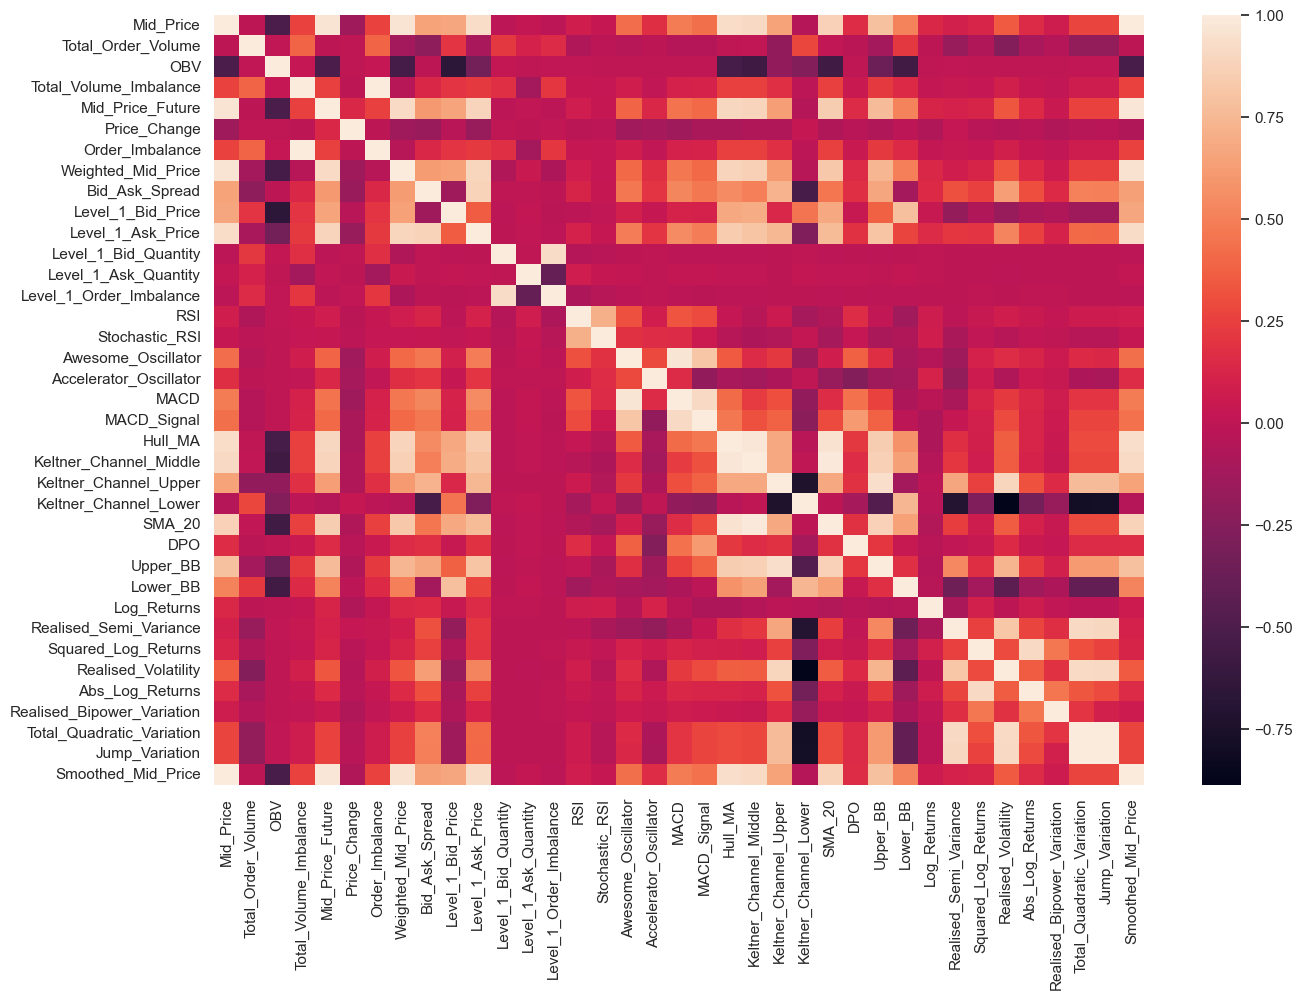

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))
columns_to_drop = ['Timestamp', 'Exchange', 'Bid', 'Ask', 'Date']
feature_set = df.drop(columns_to_drop, axis=1)  # Specify axis=1 to drop columns
sns.heatmap(feature_set.corr(), ax=ax)

In [36]:
# Compute correlation matrix
correlation_matrix = feature_set.corr()

# Exclude self-correlation (diagonal elements) and duplicates
correlation_matrix = correlation_matrix.mask(np.tril(np.ones(correlation_matrix.shape)).astype(bool))

# Stack the correlation matrix and convert to DataFrame
stacked_corr = correlation_matrix.stack().reset_index()
stacked_corr.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Sort by correlation (positive correlation first)
stacked_corr_sorted = stacked_corr.sort_values(by='Correlation', ascending=False)

# Top 10 most positively correlated features
top_pos_correlated = stacked_corr_sorted.head(10)

# Top 10 most negatively correlated features
top_neg_correlated = stacked_corr_sorted.tail(10).sort_values(by='Correlation', ascending=True)

print("Top 10 most positively correlated features:")
print(top_pos_correlated)

print("\nTop 10 most negatively correlated features:")
print(top_neg_correlated)


Top 10 most positively correlated features:
                     Feature_1               Feature_2  Correlation
107     Total_Volume_Imbalance         Order_Imbalance     1.000000
663  Total_Quadratic_Variation          Jump_Variation     0.994203
35                   Mid_Price      Smoothed_Mid_Price     0.993439
548     Keltner_Channel_Middle                  SMA_20     0.991611
530                    Hull_MA  Keltner_Channel_Middle     0.977705
169           Mid_Price_Future      Smoothed_Mid_Price     0.975098
457         Awesome_Oscillator                    MACD     0.967926
3                    Mid_Price        Mid_Price_Future     0.958974
6                    Mid_Price      Weighted_Mid_Price     0.956250
533                    Hull_MA                  SMA_20     0.952693

Top 10 most negatively correlated features:
                 Feature_1                  Feature_2  Correlation
582  Keltner_Channel_Lower        Realised_Volatility    -0.886054
585  Keltner_Channel_Lower  T

In [37]:
#TODO Consider which are the most usable and explainable features, and focus on one or 2 features from key areas - view presentation